In [1]:
# imports: 
import numpy as np
import pandas as pd
import wrangle as wr

# feature selection: 
from sklearn.feature_selection import SelectKBest, \
RFE, f_regression, SequentialFeatureSelector

from sklearn.linear_model import LinearRegression


import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

# imports for modeling
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# for knn
from sklearn.neighbors import KNeighborsClassifier

# for decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# for random forest
from sklearn.ensemble import RandomForestClassifier

# for logistic regression
from sklearn.linear_model import LogisticRegression

In [2]:
# acquire the data: 
df = wr.acquire_water()

In [3]:
# prep the data:
df = wr.prep_water(df)

In [4]:
# add the bins: 
df = wr.safe_water(df)

In [5]:
# need to create dummies; 
def create_dummies(df): 
    dummies_list = []
    cat_cols = ['ph_range',
                 'hardness_range',
                 'solids_range',
                 'chloramines_range',
                 'sulfate_range',
                 'conductivity_rage',
                 'organic_car_range',
                 'trihalomethanes_range',
                 'turbidity_range']
    for col in cat_cols:
        dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
        dummies_list.append(dummies)
    df = pd.concat([df] + dummies_list, axis = 1)
    return df
                

In [6]:
df = create_dummies(df)
df

,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability,...,solids_range_good,solids_range_fair,solids_range_poor,solids_range_unacceptable,chloramines_range_high,sulfate_range_high,conductivity_rage_high,organic_car_range_high,trihalomethanes_range_high,turbidity_range_high
3,8.32,214.37,22018.42,8.06,356.89,363.27,18.44,100.34,4.63,0,...,0,0,0,1,1,1,0,1,1,0
4,9.09,181.10,17978.99,6.55,310.14,398.41,11.56,32.00,4.08,0,...,0,0,0,1,1,1,0,1,0,0
5,5.58,188.31,28748.69,7.54,326.68,280.47,8.40,54.92,2.56,0,...,0,0,0,1,1,1,0,1,0,0
6,10.22,248.07,28749.72,7.51,393.66,283.65,13.79,84.60,2.67,0,...,0,0,0,1,1,1,0,1,1,0
7,8.64,203.36,13672.09,4.56,303.31,474.61,12.36,62.80,4.40,0,...,0,0,0,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3267,8.99,215.05,15921.41,6.30,312.93,390.41,9.90,55.07,4.61,1,...,0,0,0,1,1,1,0,1,0,0
3268,6.70,207.32,17246.92,7.71,304.51,329.27,16.22,28.88,3.44,1,...,0,0,0,1,1,1,0,1,0,0
3269,11.49,94.81,37188.83,9.26,258.93,439.89,16.17,41.56,4.37,1,...,0,0,0,1,1,1,1,1,0,0
3270,6.07,186.66,26138.78,7.75,345.70,415.89,12.07,60.42,3.67,1,...,0,0,0,1,1,1,1,1,0,0


In [7]:
# split the data
train, validate, test = wr.split_water(df)

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# need to drop non dummy columns
def drop_columns(train, val, test):
    
    dropcols = ['ph_range',
 'hardness_range',
 'solids_range',
 'chloramines_range',
 'sulfate_range',
 'conductivity_rage',
 'organic_car_range',
 'trihalomethanes_range',
 'turbidity_range']
    
    train.drop(columns = dropcols, inplace = True)
    val.drop(columns = dropcols, inplace=True)
    test.drop(columns = dropcols, inplace=True)
    return train, val, test

In [10]:
train, validate, test = drop_columns(train, validate, test)

In [11]:
df.columns

Index(['ph', 'hardness', 'solids', 'chloramines', 'sulfate', 'conductivity',
       'organic_carbon', 'trihalomethanes', 'turbidity', 'potability',
       'ph_range', 'hardness_range', 'solids_range', 'chloramines_range',
       'sulfate_range', 'conductivity_rage', 'organic_car_range',
       'trihalomethanes_range', 'turbidity_range', 'ph_range_safe',
       'ph_range_basic', 'hardness_range_slightly_hard',
       'hardness_range_moderately_hard', 'hardness_range_hard',
       'hardness_range_very_hard', 'solids_range_good', 'solids_range_fair',
       'solids_range_poor', 'solids_range_unacceptable',
       'chloramines_range_high', 'sulfate_range_high',
       'conductivity_rage_high', 'organic_car_range_high',
       'trihalomethanes_range_high', 'turbidity_range_high'],
      dtype='object')

In [12]:
# split data in X_train, and y_train
X_train = train.drop(columns = 'potability')
y_train = train[['potability']]

X_validate = validate.drop(columns = 'potability')
y_validate = validate[['potability']]

X_test = test.drop(columns = 'potability')
y_test = test[['potability']]

# Feature Engineering:

In [13]:
# Select K-best: 
kbest = SelectKBest(f_regression, k = 2)

# fit the thing: 
kbest.fit(X_train, y_train)

SelectKBest(k=2, score_func=<function f_regression at 0x16356b2e0>)

In [14]:
# statiscal f-value / featurer's scores:
kbest.scores_

array([0.28089469, 0.54203547, 1.67963804, 3.37603307, 0.44668075,
       1.84300057, 0.28437023, 0.10380437, 0.0244078 , 7.49394409,
       2.67420243, 0.        , 3.30035314, 0.33286598, 1.20419496,
       0.        , 0.        , 0.        , 0.        , 0.26945535,
       1.96984464, 1.53530192, 0.        , 0.16746606, 0.01346066])

In [15]:
# p value: 
kbest.pvalues_

array([0.59622017, 0.46174414, 0.19523884, 0.06641518, 0.50405279,
       0.1748724 , 0.59395653, 0.7473711 , 0.87587985, 0.00628846,
       0.10226664, 1.        , 0.06953147, 0.56409198, 0.27272009,
       1.        , 1.        , 1.        , 1.        , 0.60379964,
       0.1607408 , 0.21557736, 1.        , 0.68245172, 0.90765738])

In [16]:
# get the names of the features its looking at: 
kbest.feature_names_in_

array(['ph', 'hardness', 'solids', 'chloramines', 'sulfate',
       'conductivity', 'organic_carbon', 'trihalomethanes', 'turbidity',
       'ph_range_safe', 'ph_range_basic', 'hardness_range_slightly_hard',
       'hardness_range_moderately_hard', 'hardness_range_hard',
       'hardness_range_very_hard', 'solids_range_good',
       'solids_range_fair', 'solids_range_poor',
       'solids_range_unacceptable', 'chloramines_range_high',
       'sulfate_range_high', 'conductivity_rage_high',
       'organic_car_range_high', 'trihalomethanes_range_high',
       'turbidity_range_high'], dtype=object)

In [17]:
kbest_results = pd.DataFrame(
                dict(p=kbest.pvalues_, f=kbest.scores_),
                                        index = X_train.columns)

In [18]:
kbest_results

,p,f
ph,0.596220,0.280895
hardness,0.461744,0.542035
solids,0.195239,1.679638
chloramines,0.066415,3.376033
sulfate,0.504053,0.446681
conductivity,0.174872,1.843001
organic_carbon,0.593957,0.284370
trihalomethanes,0.747371,0.103804
turbidity,0.875880,0.024408
ph_range_safe,0.006288,7.493944


In [19]:
#RFE:
model = LinearRegression()

In [20]:
# make it: 
rfe = RFE(model, n_features_to_select= 2)

# Fit the thing:
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=2)

In [21]:
# get the feature ranking:
rfe.ranking_

array([ 9, 14, 18,  7, 16, 15, 13, 17, 12,  4,  8, 19,  1,  1,  2, 22, 20,
       21, 23,  6,  3,  5, 24, 11, 10])

In [22]:
# make a dataframe of the rankings for better understanding
pd.DataFrame(
{
    'rfe_ranking':rfe.ranking_
}, index = X_train.columns)

,rfe_ranking
ph,9
hardness,14
solids,18
chloramines,7
sulfate,16
conductivity,15
organic_carbon,13
trihalomethanes,17
turbidity,12
ph_range_safe,4


In [23]:
#SFS
model = LinearRegression()

# MAKE the thing
sfs = SequentialFeatureSelector(model, n_features_to_select=2)

# FIT the thing
sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select=2)

In [24]:
sfs.support_

array([False, False, False, False, False, False, False, False, False,
        True, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [25]:
X_train_SFStransformed = pd.DataFrame(
                            sfs.transform(X_train),
                            index = X_train.index,
                            columns = X_train.columns[sfs.support_])

In [26]:
X_train_SFStransformed.head()

,ph_range_safe,hardness_range_moderately_hard
2719,0.0,0.0
3230,0.0,1.0
1502,0.0,0.0
978,1.0,0.0
1114,1.0,0.0


# Modeling: 
- Decision Tree
- Random Forest
- KNN
- Linear Regression
Confusion matrix Prediction: 
- positive =  safe, potable
- negative = not safe, not potable

In [27]:
# acquire the data: 
df = wr.acquire_water()

In [28]:
# prep the data:
df = wr.prep_water(df)

In [29]:
# using wrangle safe water, create new features: 
df = wr.safe_water(df)

In [30]:
# using wrange create_dummies, make dummies for these features
df = wr.create_dummies(df)

In [31]:
# using wrange split, make train, validate, test
train, validate, test = wr.split_water(df)

In [32]:
# prepocessing: using wrangle drop columns to remove duplicate columns for modeling
train, validate, test = wr.drop_columns(train, validate, test)

In [33]:
train.columns

Index(['ph', 'hardness', 'solids', 'chloramines', 'sulfate', 'conductivity',
       'organic_carbon', 'trihalomethanes', 'turbidity', 'potability',
       'ph_range_safe', 'ph_range_basic', 'hardness_range_slightly_hard',
       'hardness_range_moderately_hard', 'hardness_range_hard',
       'hardness_range_very_hard', 'solids_range_good', 'solids_range_fair',
       'solids_range_poor', 'solids_range_unacceptable',
       'chloramines_range_high', 'sulfate_range_high',
       'conductivity_rage_high', 'organic_car_range_high',
       'trihalomethanes_range_high', 'turbidity_range_high'],
      dtype='object')

In [34]:
# create Feature selection: 
set_features = ['ph','hardness','chloramines','conductivity','ph_range_safe',
                'hardness_range_moderately_hard', 'hardness_range_hard'] 
all_features = ['ph', 'hardness', 'solids', 'chloramines', 'sulfate', 'conductivity',
       'organic_carbon', 'trihalomethanes', 'turbidity',
       'ph_range_safe', 'ph_range_basic', 'hardness_range_slightly_hard',
       'hardness_range_moderately_hard', 'hardness_range_hard',
       'hardness_range_very_hard', 'solids_range_good', 'solids_range_fair',
       'solids_range_poor', 'solids_range_unacceptable',
       'chloramines_range_high', 'sulfate_range_high',
       'conductivity_rage_high', 'organic_car_range_high',
       'trihalomethanes_range_high', 'turbidity_range_high']

# Phases: 
1. Run phase one using all features. Record Data.
    - To do this change the list on X vairbales to be:
        - train[all_features]
        - validate[all_features]
        - test[all_features]
    - Run the entire notebook.
2. Run phase two using set features. Record Data.
    - To do this, change the list on X variables to be: 
        - train[set_features]
        - validate[set_features]
        - test[set_features]
    - Run the entire notebook.

In [35]:
# create our x and y: 
X_train = train[all_features]
y_train = train.potability

X_val = validate[all_features]
y_val = validate.potability

X_test = test[all_features]
y_test = test.potability

In [36]:
# The mode is a great baseline
baseline = y_train.mode()

# Produce a boolean array with True representing a match between the baseline prediction and reality
matches_baseline_prediction = y_train == 0

baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

Baseline accuracy: 0.6


In [37]:
# double check the data frames are all the same: 
print(type(X_train))
print(type(y_train))
print(type(X_val))
print(type(y_val))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


# Decision Tree: 

In [38]:
# create the model: 
clf = DecisionTreeClassifier(max_depth=3, random_state=123)

In [39]:
#fit the model
clf = clf.fit(X_train, y_train)

In [40]:
clf.score(X_train, y_train)

0.6435555555555555

In [41]:
y_pred = clf.predict(X_train)

In [42]:
conf = confusion_matrix(y_train, y_pred)
conf

array([[666,   6],
       [395,  58]])

In [43]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.99      0.77       672
           1       0.91      0.13      0.22       453

    accuracy                           0.64      1125
   macro avg       0.77      0.56      0.50      1125
weighted avg       0.74      0.64      0.55      1125



In [44]:
conf

array([[666,   6],
       [395,  58]])

In [45]:
TN, FP, FN, TP = conf.ravel()
TN, FP, FN, TP

(666, 6, 395, 58)

In [46]:
all_ = (TP + TN + FP + FN)

accuracy = (TP + TN) / all_

TPR = recall = TP / (TP + FN)
FPR = FP / (FP + TN)

TNR = TN / (FP + TN)
FNR = FN / (FN + TP)

recall = TP / (TP + FN)
precision =  TP / (TP + FP)
f1 =  2 * ((precision * recall) / ( precision + recall))

support_pos = TP + FN
support_neg = FP + TN

In [47]:
print(f"Accuracy: {accuracy}\n")
print(f"True Positive Rate/Sensitivity/Recall/Power: {TPR}")
print(f"False Positive Rate/False Alarm Ratio/Fall-out: {FPR}")
print(f"True Negative Rate/Specificity/Selectivity: {TNR}")
print(f"False Negative Rate/Miss Rate: {FNR}\n")
print(f"Precision/PPV: {precision}")
print(f'Recall{recall}')
print(f"F1 Score: {f1}\n")
print(f"Support (0): {support_pos}")
print(f"Support (1): {support_neg}")

Accuracy: 0.6435555555555555

True Positive Rate/Sensitivity/Recall/Power: 0.1280353200883002
False Positive Rate/False Alarm Ratio/Fall-out: 0.008928571428571428
True Negative Rate/Specificity/Selectivity: 0.9910714285714286
False Negative Rate/Miss Rate: 0.8719646799116998

Precision/PPV: 0.90625
Recall0.1280353200883002
F1 Score: 0.2243713733075435

Support (0): 453
Support (1): 672


In [48]:
#for lots
for x in range(1,20):
#     print(x)
    clf = DecisionTreeClassifier(max_depth=x)
    clf.fit(X_train, y_train)
    acc = clf.score(X_train, y_train)
    print(f'for depth of {x:2}, the accuracy is {round(acc,2)}')

for depth of  1, the accuracy is 0.62
for depth of  2, the accuracy is 0.64
for depth of  3, the accuracy is 0.64
for depth of  4, the accuracy is 0.68
for depth of  5, the accuracy is 0.71
for depth of  6, the accuracy is 0.73
for depth of  7, the accuracy is 0.74
for depth of  8, the accuracy is 0.75
for depth of  9, the accuracy is 0.78
for depth of 10, the accuracy is 0.81
for depth of 11, the accuracy is 0.85
for depth of 12, the accuracy is 0.87
for depth of 13, the accuracy is 0.89
for depth of 14, the accuracy is 0.9
for depth of 15, the accuracy is 0.92
for depth of 16, the accuracy is 0.93
for depth of 17, the accuracy is 0.94
for depth of 18, the accuracy is 0.95
for depth of 19, the accuracy is 0.97


In [49]:
scores_all = []

for x in range(1,20):

    clf = DecisionTreeClassifier(max_depth=x)
    clf.fit(X_train, y_train)
    train_acc = clf.score(X_train, y_train)
    
    #evaluate on validate
    val_acc = clf.score(X_val, y_val)
    
    scores_all.append([x, train_acc, val_acc])

In [50]:

scores_df = pd.DataFrame(scores_all, columns=['max_depth','train_acc','val_acc'])
scores_df.head()

,max_depth,train_acc,val_acc
0,1,0.624889,0.602484
1,2,0.639111,0.614907
2,3,0.643556,0.612836
3,4,0.680889,0.623188
4,5,0.708444,0.635611


In [51]:
scores_df['diff'] = scores_df.train_acc - scores_df.val_acc

In [52]:
scores_df.sort_values('diff').head(7)

,max_depth,train_acc,val_acc,diff
0,1,0.624889,0.602484,0.022404
1,2,0.639111,0.614907,0.024204
2,3,0.643556,0.612836,0.030719
3,4,0.680889,0.623188,0.057700
4,5,0.708444,0.635611,0.072834
5,6,0.726222,0.623188,0.103034
6,7,0.737778,0.621118,0.116660


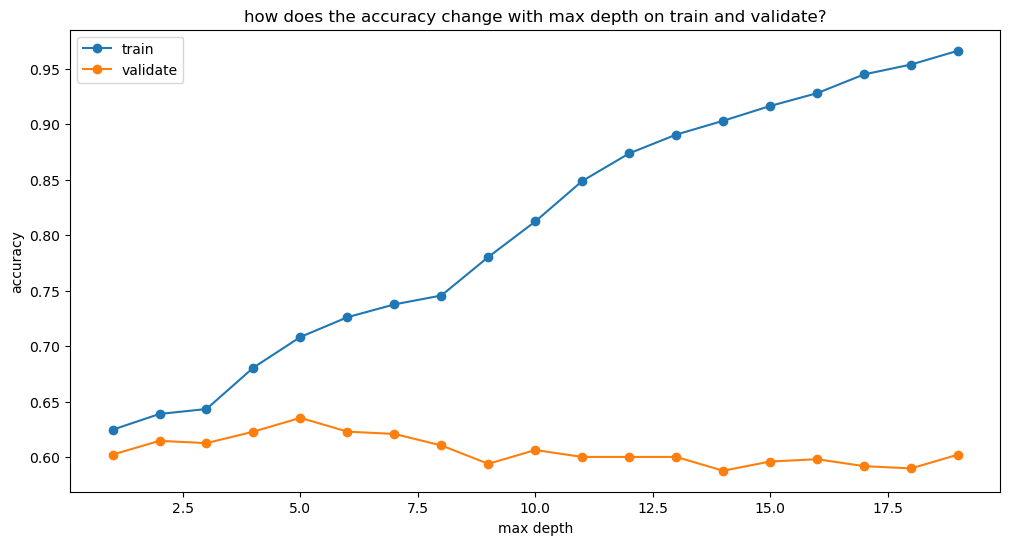

In [53]:
plt.figure(figsize=(12,6))
plt.plot(scores_df.max_depth, scores_df.train_acc, label='train', marker='o')
plt.plot(scores_df.max_depth, scores_df.val_acc, label='validate', marker='o')
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.title('how does the accuracy change with max depth on train and validate?')
plt.legend()
plt.show()

# Random Forest: 

In [54]:
# The mode is a great baseline
baseline = y_train.mode()

# Produce a boolean array with True representing a match between the baseline prediction and reality
matches_baseline_prediction = y_train == 0

baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

Baseline accuracy: 0.6


In [55]:
# Make the model
forest1 = RandomForestClassifier(max_depth=1, random_state=124)

# Fit the model (on train and only train)
forest1.fit(X_train, y_train)

# Use the model
# We'll evaluate the model's performance on train, first
y_predictions = forest1.predict(X_train)

# Produce the classification report on the actual y values and this model's predicted y values
report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of 1 depth")
pd.DataFrame(report)

Tree of 1 depth


,0,1,accuracy,macro avg,weighted avg
precision,0.597865,1.000000,0.598222,0.798932,0.759791
recall,1.000000,0.002208,0.598222,0.501104,0.598222
f1-score,0.748330,0.004405,0.598222,0.376367,0.448776
support,672.000000,453.000000,0.598222,1125.000000,1125.000000


In [56]:
# sklearn confusion matrix
pd.DataFrame(confusion_matrix(y_predictions, y_train))

,0,1
0,672,452
1,0,1


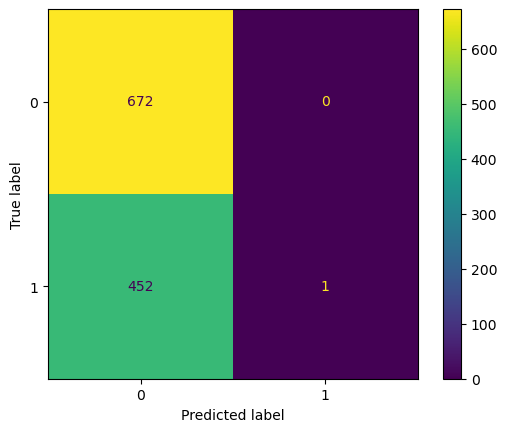

In [57]:
ConfusionMatrixDisplay.from_estimator(forest1, X_train, y_train);

In [58]:
TN, FP, FN, TP = confusion_matrix(y_train,y_predictions).ravel()
ALL = TP + TN + FP + FN

TP, TN, FP, FN

(1, 672, 0, 452)

In [59]:

accuracy = (TP + TN)/ALL
print(f"Accuracy: {accuracy}")

true_positive_rate = TP/(TP+FN)
print(f"True Positive Rate: {true_positive_rate}")

false_positive_rate = FP/(FP+TN)
print(f"False Positive Rate: {false_positive_rate}")

true_negative_rate = TN/(TN+FP)
print(f"True Negative Rate: {true_negative_rate}")

false_negative_rate = FN/(FN+TP)
print(f"False Negative Rate: {false_negative_rate}")

precision = TP/(TP+FP)
print(f"Precision: {precision}")

recall = TP/(TP+FN)
print(f"Recall: {recall}")

f1_score = 2*(precision*recall)/(precision+recall)
print(f"F1 Score: {f1_score}")

support_pos = TP + FN
print(f"Support (0): {support_pos}")

support_neg = FP + TN
print(f"Support (1): {support_neg}")

Accuracy: 0.5982222222222222
True Positive Rate: 0.002207505518763797
False Positive Rate: 0.0
True Negative Rate: 1.0
False Negative Rate: 0.9977924944812362
Precision: 1.0
Recall: 0.002207505518763797
F1 Score: 0.004405286343612334
Support (0): 453
Support (1): 672


In [60]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []

for i in range(2, 25):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_val, y_val)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.625778,0.619048,0.006730
1,3,0.656889,0.621118,0.035771
2,4,0.679111,0.629400,0.049712
3,5,0.705778,0.616977,0.088801
4,6,0.730667,0.633540,0.097126
5,7,0.777778,0.648033,0.129745
6,8,0.817778,0.648033,0.169745
7,9,0.872000,0.637681,0.234319
8,10,0.896889,0.621118,0.275771
9,11,0.928889,0.639752,0.289137


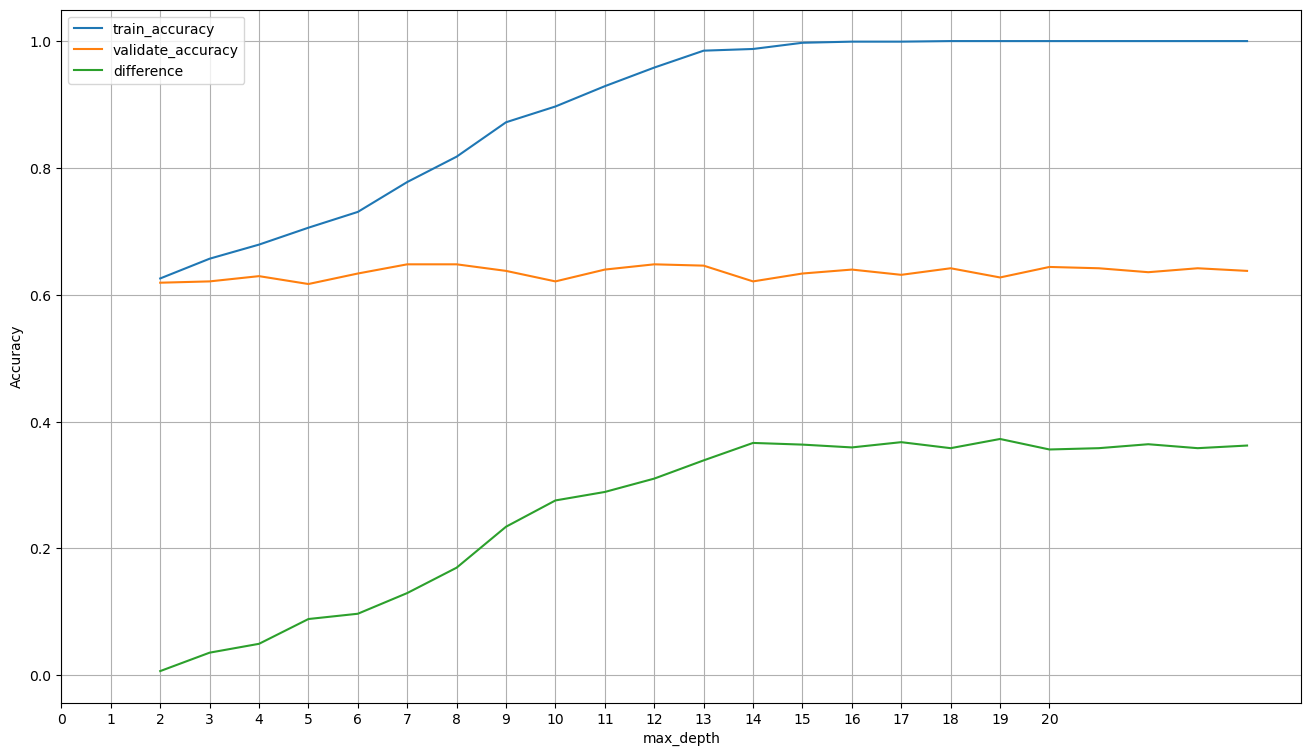

In [61]:
df.set_index('max_depth').plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()

In [62]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []
max_depth = 8

for i in range(2, max_depth):
    # Make the model
    depth = i
    n_samples = i
    forest = RandomForestClassifier(max_depth=depth, min_samples_leaf=n_samples, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_val, y_val)

    output = {
        "min_samples_per_leaf": n_samples,
        "max_depth": depth,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,min_samples_per_leaf,max_depth,train_accuracy,validate_accuracy,difference
0,2,2,0.626667,0.619048,0.007619
1,3,3,0.656000,0.625259,0.030741
2,4,4,0.671111,0.633540,0.037571
3,5,5,0.687111,0.627329,0.059782
4,6,6,0.705778,0.631470,0.074308
5,7,7,0.728889,0.621118,0.107771


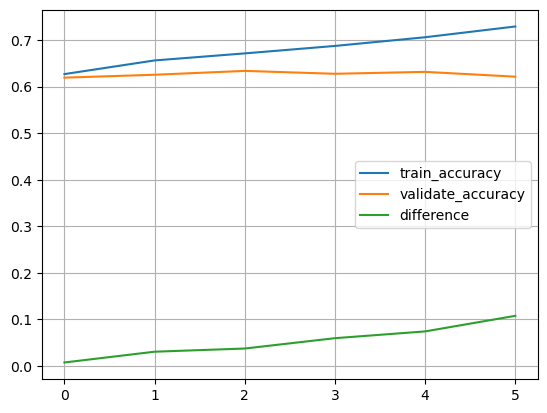

In [63]:
df[['train_accuracy', 'validate_accuracy','difference']].plot()
plt.grid()

# Logistic Regression: 

In [64]:

metrics = []

for c in np.arange(0.0001,0.1, 0.001):
     # base line
    baseline_accuracy = (train.potability == 0).mean()
    
    # create ramdom tree object
    logReg = LogisticRegression(C=c, random_state=123, max_iter= 1000)
    
    # fit the model
    randFor = logReg.fit(X_train, y_train)
    
    # get accuracy scores
    train_score = randFor.score(X_train, y_train)
    validate_score = randFor.score(X_val, y_val)
    
    # create a dictionary of scores
    output = {
        "C": c,
        "train_score": train_score,
         "validate_score": validate_score,
        "difference": train_score - validate_score,
        "train_baseline_diff": baseline_accuracy - train_score,
        "validate_baseline_diff": baseline_accuracy - validate_score,
        "baseline_accuracy": baseline_accuracy
    }
    
    metrics.append(output)

In [65]:
# get the result as a dataframe
model_df = pd.DataFrame(metrics)
model_df

,C,train_score,validate_score,difference,train_baseline_diff,validate_baseline_diff,baseline_accuracy
0,0.0001,0.597333,0.596273,0.001060,0.000000,0.001060,0.597333
1,0.0011,0.599111,0.590062,0.009049,-0.001778,0.007271,0.597333
2,0.0021,0.596444,0.596273,0.000171,0.000889,0.001060,0.597333
3,0.0031,0.596444,0.596273,0.000171,0.000889,0.001060,0.597333
4,0.0041,0.607111,0.606625,0.000486,-0.009778,-0.009292,0.597333
...,...,...,...,...,...,...,...
95,0.0951,0.616000,0.612836,0.003164,-0.018667,-0.015503,0.597333
96,0.0961,0.609778,0.604555,0.005223,-0.012444,-0.007222,0.597333
97,0.0971,0.609778,0.604555,0.005223,-0.012444,-0.007222,0.597333
98,0.0981,0.609778,0.604555,0.005223,-0.012444,-0.007222,0.597333


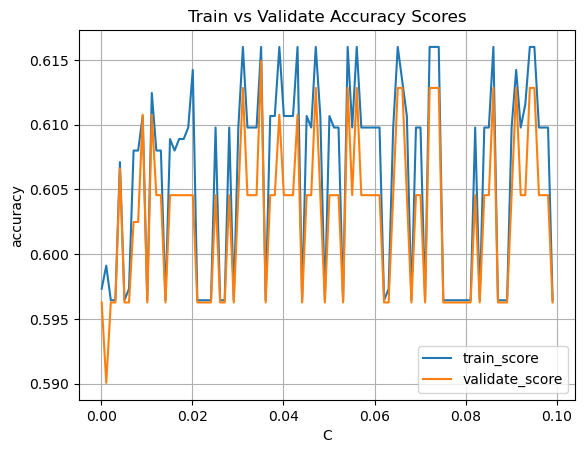

In [66]:
model_df[model_df.columns[:-4]].set_index("C").plot()
plt.ylabel('accuracy')
plt.xlabel('C')
plt.title("Train vs Validate Accuracy Scores")
plt.grid()
plt.show()

In [67]:
# find the model with smallest ifference between the train and validate
high_models = model_df[(model_df.C > 0.045) & (model_df.C < 0.055)]

high_models[high_models.difference == high_models.difference.min()]

,C,train_score,validate_score,difference,train_baseline_diff,validate_baseline_diff,baseline_accuracy
49,0.0491,0.596444,0.596273,0.000171,0.000889,0.00106,0.597333
53,0.0531,0.596444,0.596273,0.000171,0.000889,0.00106,0.597333


# KNN

In [68]:
print("X_train type:", type(X_train))
print("X_train shape:", X_train.shape)
print("y_train type:", type(y_train))
print("y_train shape:", y_train.shape)

X_train type: <class 'pandas.core.frame.DataFrame'>
X_train shape: (1125, 25)
y_train type: <class 'pandas.core.series.Series'>
y_train shape: (1125,)


In [69]:
X_train_numpy = X_train.values

In [70]:
print(X_train_numpy.flags)

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



In [71]:
X_train = np.ascontiguousarray(X_train_numpy)

In [72]:
print(X_train_numpy.flags)

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False



In [73]:
type(X_train)

numpy.ndarray

In [74]:
# work X-Train out: 
X_val = np.ascontiguousarray(X_val.values)
X_test = np.ascontiguousarray(X_test.values)

In [75]:
# Make the KNN classifier
knn = KNeighborsClassifier()

# Fit the KNN classifier
knn.fit(X_train, y_train)

# Use the trained classifier
y_train_pred = knn.predict(X_train)

In [76]:
#get the accuracy score of train set
train_score = knn.score(X_train, y_train)
train_score

0.6933333333333334

In [77]:
#confusion matrix
cm = confusion_matrix(y_train, y_train_pred)
pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], 
             columns=['Pred 0', 'Pred 1'])

,Pred 0,Pred 1
Actual 0,551,121
Actual 1,224,229


In [78]:
#classification report
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.71      0.82      0.76       672
           1       0.65      0.51      0.57       453

    accuracy                           0.69      1125
   macro avg       0.68      0.66      0.67      1125
weighted avg       0.69      0.69      0.68      1125



In [79]:
#classification report as a df
pd.DataFrame(classification_report(y_train, 
                                   y_train_pred, 
                                   output_dict=True)).T

,precision,recall,f1-score,support
0,0.710968,0.819940,0.761576,672.000000
1,0.654286,0.505519,0.570361,453.000000
accuracy,0.693333,0.693333,0.693333,0.693333
macro avg,0.682627,0.662730,0.665968,1125.000000
weighted avg,0.688144,0.693333,0.684580,1125.000000


In [80]:
tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn)/(tn + fp + fn + tp)

true_positive_rate = tp/(tp + fn)
false_positive_rate = fp/(fp + tn)
true_negative_rate = tn/(tn + fp)
false_negative_rate = fn/(fn + tp)

precision = tp/(tp + fp)
recall = tp/(tp + fn)
f1_score = 2*(precision*recall)/(precision+recall)

support_pos = tp + fn
support_neg = fp + tn

dict = {
    'metric' : ['accuracy'
                ,'true_positive_rate'
                ,'false_positive_rate'
                ,'true_negative_rate'
                ,'false_negative_rate'
                ,'precision'
                ,'recall'
                ,'f1_score'
                ,'support_pos'
                ,'support_neg']
    ,'score' : [accuracy
                ,true_positive_rate
                ,false_positive_rate
                ,true_negative_rate
                ,false_negative_rate
                ,precision
                ,recall
                ,f1_score
                ,support_pos
                ,support_neg]
}

pd.DataFrame(dict)

,metric,score
0,accuracy,0.693333
1,true_positive_rate,0.505519
2,false_positive_rate,0.180060
3,true_negative_rate,0.819940
4,false_negative_rate,0.494481
5,precision,0.654286
6,recall,0.505519
7,f1_score,0.570361
8,support_pos,453.000000
9,support_neg,672.000000


In [81]:
def print_cm_metrics(cm):
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn)/(tn + fp + fn + tp)

    true_positive_rate = tp/(tp + fn)
    false_positive_rate = fp/(fp + tn)
    true_negative_rate = tn/(tn + fp)
    false_negative_rate = fn/(fn + tp)

    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    f1_score = 2*(precision*recall)/(precision+recall)

    support_pos = tp + fn
    support_neg = fp + tn

    dict = {
        'metric' : ['accuracy'
                    ,'true_positive_rate'
                    ,'false_positive_rate'
                    ,'true_negative_rate'
                    ,'false_negative_rate'
                    ,'precision'
                    ,'recall'
                    ,'f1_score'
                    ,'support_pos'
                    ,'support_neg']
        ,'score' : [accuracy
                    ,true_positive_rate
                    ,false_positive_rate
                    ,true_negative_rate
                    ,false_negative_rate
                    ,precision
                    ,recall
                    ,f1_score
                    ,support_pos
                    ,support_neg]
    }

    return pd.DataFrame(dict)

In [82]:
def knn_fit_predict(k, X_train, y_train, X_validate):
    '''
    This function takes n_neighbors, X_train,  target  and X_val
    and returns knn, predictions for train set and validate set
    '''
    # MAKE the thing
    knn = KNeighborsClassifier(n_neighbors=k)

    # FIT the thing
    knn.fit(X_train, y_train)

    # USE the thing
    y_train_pred = knn.predict(X_train)
    y_validate_pred = knn.predict(X_validate)
    
    return knn, y_train_pred, y_validate_pred

In [83]:
#Now, let's make a function to return the 
#accuracy, confusion matrix and classification report

def evaluate_clf(model, X, y, y_pred):
    '''
    This function can be used on any classification model
    It takes in a model, features, target and prediction
    and returns the accuracy, confusion matrix and classification report
    '''
    # model score
    accuracy = model.score(X, y)

    # confusion matrix
    cm = confusion_matrix(y, y_pred)
    cmdf = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], 
                       columns=['Pred 0', 'Pred 1'])

    # classification report
    crdf = pd.DataFrame(classification_report(y, y_pred, output_dict=True))
    
    # confusion matrix metrics
    metrics = print_cm_metrics(cm)
    
    return accuracy, cmdf, crdf, metrics

In [84]:
metrics = []

for k in range(1,21):
    knn, y_train_pred, y_val_pred = knn_fit_predict(k, X_train, 
                                                    y_train, 
                                                    X_val)
    train_acc = knn.score(X_train, y_train)
    val_acc = knn.score(X_val, y_val)
    
    output = {
            "k": k,
            "train_accuracy": train_acc,
            "validate_accuracy": val_acc
    }

    metrics.append(output)
    
eval_df = pd.DataFrame(metrics)
eval_df['difference'] = eval_df['train_accuracy'] - eval_df['validate_accuracy']

eval_df

,k,train_accuracy,validate_accuracy,difference
0,1,1.000000,0.532091,0.467909
1,2,0.737778,0.575569,0.162208
2,3,0.749333,0.525880,0.223453
3,4,0.688000,0.563147,0.124853
4,5,0.693333,0.552795,0.140538
5,6,0.666667,0.561077,0.105590
6,7,0.683556,0.534161,0.149394
7,8,0.664000,0.567288,0.096712
8,9,0.677333,0.552795,0.124538
9,10,0.656000,0.550725,0.105275


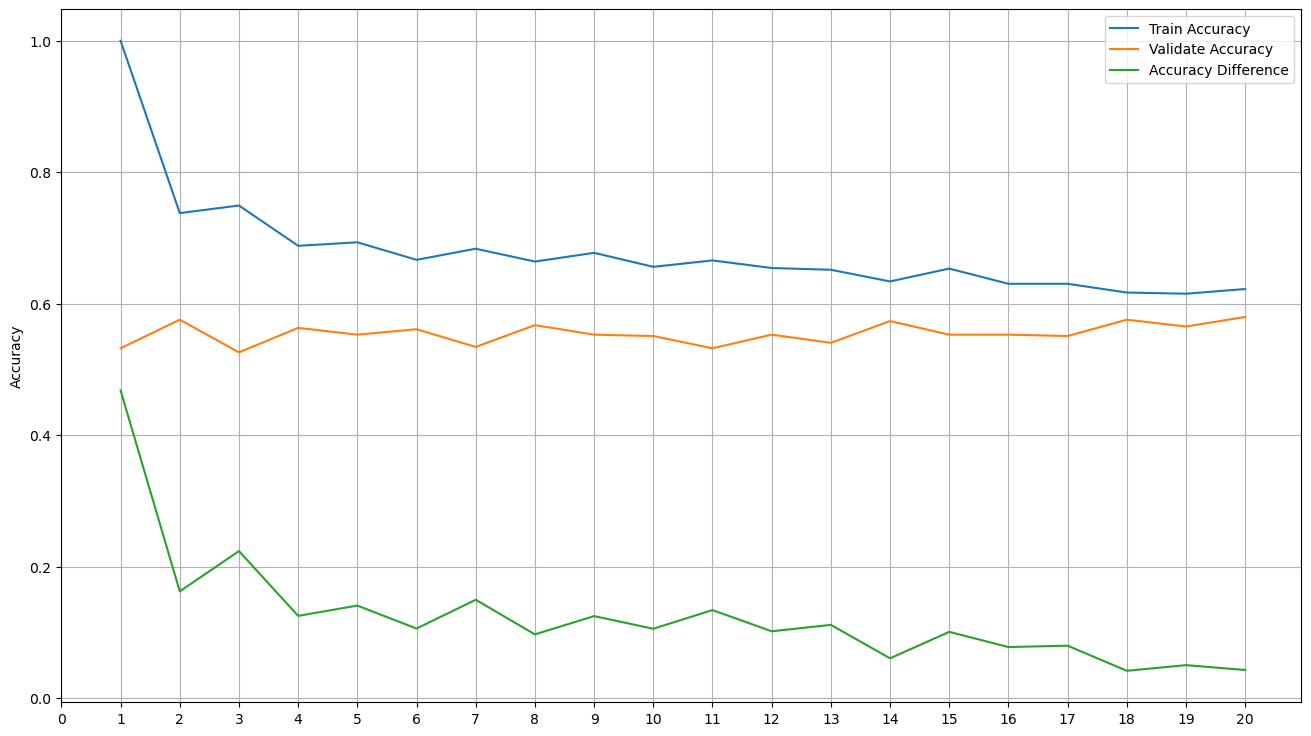

In [85]:
# plot the data
plt.figure(figsize=(16,9))
plt.plot(eval_df.k, eval_df.train_accuracy, label='Train Accuracy')
plt.plot(eval_df.k, eval_df.validate_accuracy, label='Validate Accuracy')
plt.plot(eval_df.k, eval_df.difference, label='Accuracy Difference')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(np.arange(0,21,1))
plt.grid()
plt.show()